In [2]:
import os

In [2]:
%pwd

'd:\\Kidney-Disease-Classification-DL-MLflow-DVC\\research'

In [7]:
os.chdir('../')

In [4]:
%pwd

'd:\\Kidney-Disease-Classification-DL-MLflow-DVC'

In [15]:
from dataclasses import dataclass
from pathlib import Path


@dataclass(frozen=True)
class TrainingConfig:
    root_dir: Path
    trained_model_path: Path
    updated_base_model_path: Path
    training_data: Path
    params_epochs: int
    params_batch_size: int
    params_is_augmentation: bool
    params_image_size: list

In [16]:
from KidneydiseaseClassifier.constants import *
from KidneydiseaseClassifier.utils.common import read_yaml, create_directories
import tensorflow as tf

In [17]:
class ConfigurationManager:
    def __init__(
        self,
        config_filepath = CONFIG_FILE_PATH,
        params_filepath = PARAMS_FILE_PATH):

        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)

        create_directories([self.config.artifacts_root])


    
    def get_training_config(self) -> TrainingConfig:
        training = self.config.training
        prepare_base_model = self.config.prepare_base_model
        params = self.params
        training_data = os.path.join(self.config.data_ingestion.unzip_dir, "kidney-ct-scan-image")
        create_directories([
            Path(training.root_dir)
        ])

        training_config = TrainingConfig(
            root_dir=Path(training.root_dir),
            trained_model_path=Path(training.trained_model_path),
            updated_base_model_path=Path(prepare_base_model.updated_base_model_path),
            training_data=Path(training_data),
            params_epochs=params.EPOCHS,
            params_batch_size=params.BATCH_SIZE,
            params_is_augmentation=params.AUGMENTATION,
            params_image_size=params.IMAGE_SIZE
        )

        return training_config

In [18]:
import os
import urllib.request as request
from zipfile import ZipFile
import tensorflow as tf
import time

In [19]:
class Training:
    def __init__(self, config: TrainingConfig):
        self.config = config

    
    def get_base_model(self):
        self.model = tf.keras.models.load_model(
            self.config.updated_base_model_path
        )

    def train_valid_generator(self):

        datagenerator_kwargs = dict(
            rescale = 1./255,
            validation_split=0.20
        )

        dataflow_kwargs = dict(
            target_size=self.config.params_image_size[:-1],
            batch_size=self.config.params_batch_size,
            interpolation="bilinear"
        )

        valid_datagenerator = tf.keras.preprocessing.image.ImageDataGenerator(
            **datagenerator_kwargs
        )

        self.valid_generator = valid_datagenerator.flow_from_directory(
            directory=self.config.training_data,
            subset="validation",
            shuffle=False,
            **dataflow_kwargs
        )

        if self.config.params_is_augmentation:
            train_datagenerator = tf.keras.preprocessing.image.ImageDataGenerator(
                rotation_range=40,
                horizontal_flip=True,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2,
                **datagenerator_kwargs
            )
        else:
            train_datagenerator = valid_datagenerator

        self.train_generator = train_datagenerator.flow_from_directory(
            directory=self.config.training_data,
            subset="training",
            shuffle=True,
            **dataflow_kwargs
        )

    
    @staticmethod
    def save_model(path: Path, model: tf.keras.Model):
        model.save(path)





    def train(self):
        self.steps_per_epoch = self.train_generator.samples // self.train_generator.batch_size
        self.validation_steps = self.valid_generator.samples // self.valid_generator.batch_size

        self.model.fit(
            self.train_generator,
            epochs=self.config.params_epochs,
            steps_per_epoch=self.steps_per_epoch,
            validation_steps=self.validation_steps,
            validation_data=self.valid_generator
        )

        self.save_model(
            path=self.config.trained_model_path,
            model=self.model
        )

In [12]:

try:
    config = ConfigurationManager()
    training_config = config.get_training_config()
    training = Training(config=training_config)
    training.get_base_model()
    training.train_valid_generator()
    training.train()
    
except Exception as e:
    raise e

[2025-03-26 01:05:15,345: INFO: common: yaml file: config\config.yaml loaded successfully]
[2025-03-26 01:05:15,347: INFO: common: yaml file: params.yaml loaded successfully]
[2025-03-26 01:05:15,348: INFO: common: created directory at: artifacts]
[2025-03-26 01:05:15,349: INFO: common: created directory at: artifacts\training]
Found 93 images belonging to 2 classes.
Found 372 images belonging to 2 classes.
23/23 [==============================] - 25s 1s/step - loss: 11.8832 - accuracy: 0.5983 - val_loss: 18.2197 - val_accuracy: 0.4750


In [12]:
import tensorflow as tf
import os

model_path = os.path.join("artifacts", "training", "model.h5")
model = tf.keras.models.load_model(model_path)

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [14]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
import matplotlib.pyplot as plt
import numpy as np

[2025-04-11 02:42:14,832: INFO: font_manager: generated new fontManager]


Found 93 images belonging to 2 classes.
3/3 [==============================] - 6s 2s/step
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00        48
       Tumor       1.00      1.00      1.00        45

    accuracy                           1.00        93
   macro avg       1.00      1.00      1.00        93
weighted avg       1.00      1.00      1.00        93



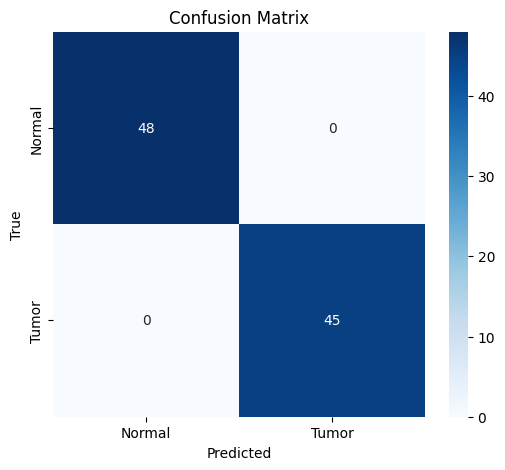

In [20]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load model
model_path = os.path.join("artifacts", "training", "model.h5")
model = tf.keras.models.load_model(model_path)

# Prepare validation generator again to get true labels
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
val_gen = datagen.flow_from_directory(
    "artifacts/data_ingestion/kidney-ct-scan-image",
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

# Predict
preds = model.predict(val_gen)
y_pred = np.argmax(preds, axis=1)
y_true = val_gen.classes

# Print classification report
print(classification_report(y_true, y_pred, target_names=list(val_gen.class_indices.keys())))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=val_gen.class_indices.keys(), yticklabels=val_gen.class_indices.keys(), cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [21]:
print(val_gen.class_indices)


{'Normal': 0, 'Tumor': 1}


In [24]:
img_path = "artifacts/data_ingestion/kidney-ct-scan-image/Tumor/Tumor- (8).jpg"
img = load_img(img_path, target_size=(224, 224))
img_array = img_to_array(img) / 255.
img_array = np.expand_dims(img_array, axis=0)

prediction = model.predict(img_array)
print("Raw prediction:", prediction)
print("Class:", list(val_gen.class_indices.keys())[np.argmax(prediction)])


1/1 [==============================] - 0s 171ms/step
Raw prediction: [[0.8379265 0.1620735]]
Class: Normal


In [26]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the path to your training data
data_dir = "artifacts/data_ingestion/kidney-ct-scan-image"

# Initialize data generator with validation split
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

val_gen = val_datagen.flow_from_directory(
    directory=data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

print("Class indices:", val_gen.class_indices)


Found 93 images belonging to 2 classes.
Class indices: {'Normal': 0, 'Tumor': 1}


1/1 [==============================] - 0s 91ms/step


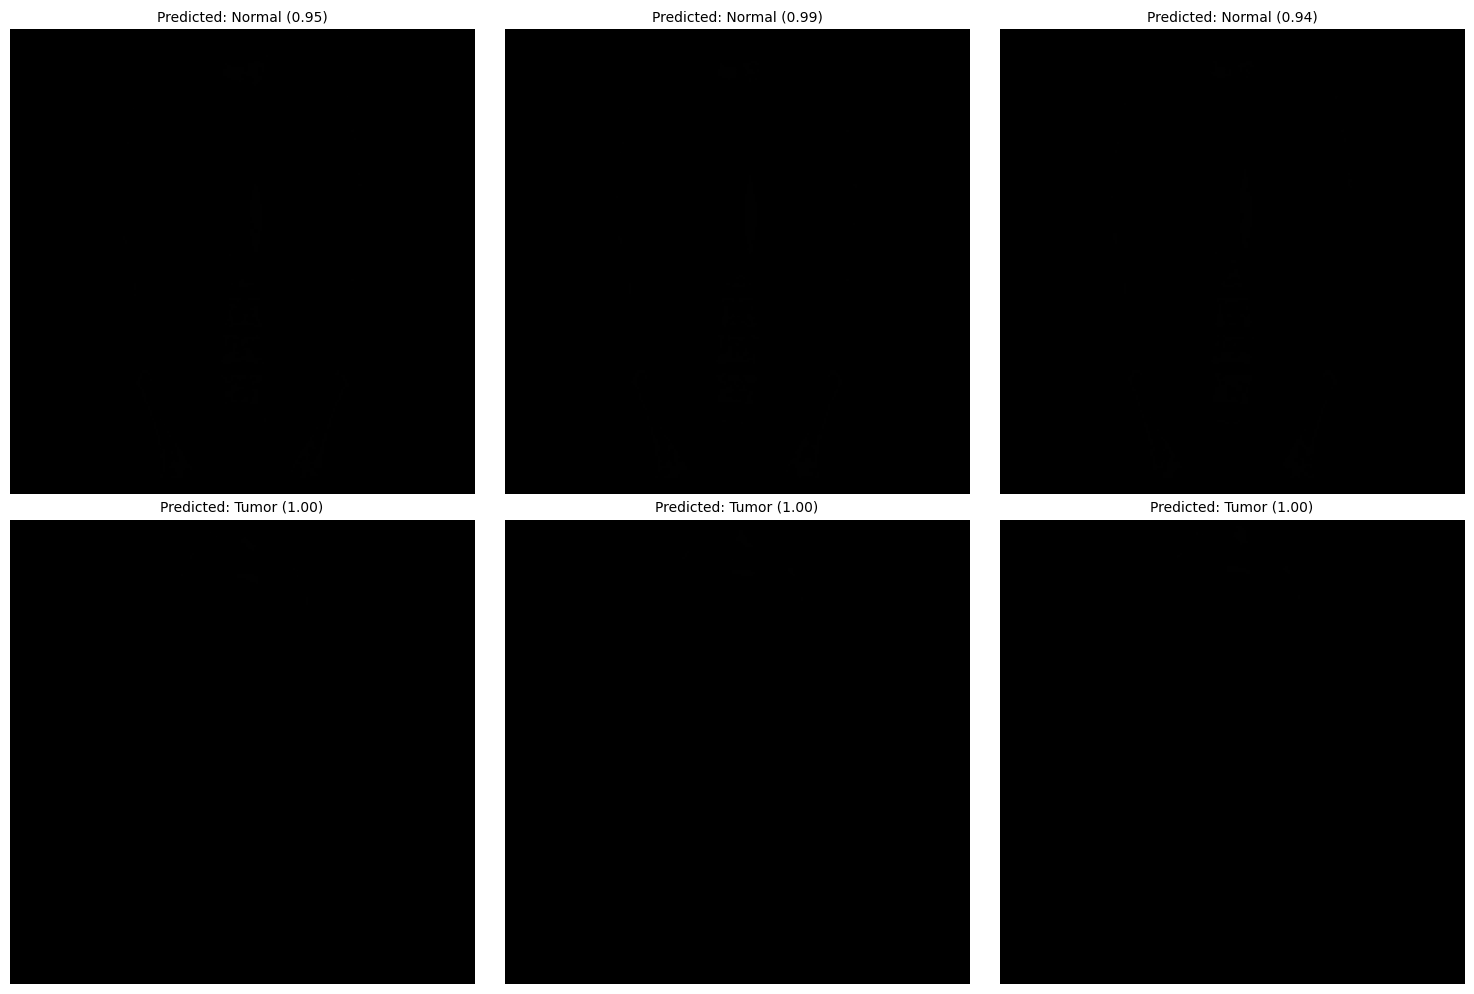

In [28]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np
import os

# Directories for each class
normal_dir = "artifacts/data_ingestion/kidney-ct-scan-image/Normal"
tumor_dir = "artifacts/data_ingestion/kidney-ct-scan-image/Tumor"

# Load 3 images from each class
normal_images = [os.path.join(normal_dir, f) for f in os.listdir(normal_dir)[:3]]
tumor_images = [os.path.join(tumor_dir, f) for f in os.listdir(tumor_dir)[:3]]
all_images = normal_images + tumor_images

# Mapping class indices to labels
class_labels = list(val_gen.class_indices.keys())  # e.g., ['Normal', 'Tumor']

plt.figure(figsize=(15, 10))

for i, img_path in enumerate(all_images):
    # Load image
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img) / 255.0
    img_array_expanded = np.expand_dims(img_array, axis=0)

    # Prediction
    prediction = model.predict(img_array_expanded)[0]
    predicted_label = class_labels[np.argmax(prediction)]
    confidence = np.max(prediction)

    # Plotting
    plt.subplot(2, 3, i + 1)
    plt.imshow(img_array.astype("uint8"))  # Use the numpy version of the image
    plt.title(f"Predicted: {predicted_label} ({confidence:.2f})", fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()

